#### Imports & Downloads

In [56]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
import time
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek, SMOTEENN

from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

### Daten

#### Originaldaten ohne umfassende Vorverarbeitung

In [2]:
current_dir = os.getcwd()
csv_path_train = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/train_basic_cleaned.csv'))
df = pd.read_csv(csv_path_train, encoding='utf-8', index_col=0)

df.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [3]:
df['label'].value_counts()
positive = len(df[df['label'] == 1])
negative = len(df[df['label'] == 0])
print("Positive:", positive)
print("Negative:", negative)
print("Verhältnis:", negative / positive)

Positive: 2013
Negative: 27517
Verhältnis: 13.669647292598112


#### Vorverarbeitete Daten

In [4]:
current_dir = os.getcwd()
csv_path_train = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/train_cleaned.csv'))
df_cleaned = pd.read_csv(csv_path_train, encoding='utf-8', index_col=0)

df_cleaned.head()

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
id,,,,,,
1,0,@user when a father is dysfunctional and is s...,father selfish drag kid run,1,['#run'],NaN
2,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit use cause offer van,2,"['#lyft', '#disapointed', '#getthanked']",NaN
3,0,bihday your majesty,bihday majesty,0,[],NaN
4,0,#model i love u take with u all the time in ...,model take time mobile phone kiss sunglass mou...,0,['#model'],":mobile_phone:,:kissing_face_with_smiling_eyes..."
5,0,factsguide: society now #motivation,factsguide society motivation,0,['#motivation'],NaN


In [5]:
df_cleaned.dropna(subset=['tweet_cleaned'],
                  inplace=True)  #irgendwoher kommt eine na row in tweet_cleaned, dadurch funktioniert der Vectorizer nicht

In [6]:
df_cleaned['label'].value_counts()
positive = len(df_cleaned[df_cleaned['label'] == 1])
negative = len(df_cleaned[df_cleaned['label'] == 0])
print("Positive:", positive)
print("Negative:", negative)
print("Verhältnis:", negative / positive)

Positive: 1811
Negative: 25838
Verhältnis: 14.267255659856433


Verhältnis hat sich durch die Bereinigung sogar noch weiter verschlechter

### Train/Test Split

In [7]:
def print_pos_neg(y_train, y_test):
    positive = np.count_nonzero(y_train == 1)
    negative = np.count_nonzero(y_train == 0)
    print("Train")
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

    positive = np.count_nonzero(y_test == 1)
    negative = np.count_nonzero(y_test == 0)
    print("Test")
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [8]:
X_base = df["tweet"]
y_base = df["label"]

In [9]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.3, stratify=y_base,
                                                                        random_state=42)
print_pos_neg(y_train_base, y_test_base)

Train
- Positive: 1409
- Negative: 19262
- Verhältnis: 13.67068843151171
Test
- Positive: 604
- Negative: 8255
- Verhältnis: 13.667218543046358


In [12]:
X_clean = df_cleaned["tweet_cleaned"]
y_clean = df_cleaned["label"]

In [13]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.3,
                                                                            stratify=y_clean, random_state=42)
print_pos_neg(y_train_clean, y_test_clean)

Train
- Positive: 1268
- Negative: 18086
- Verhältnis: 14.263406940063092
Test
- Positive: 543
- Negative: 7752
- Verhältnis: 14.276243093922652


### Vektorisierung

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_base = vectorizer.fit_transform(X_train_base)
X_test_base = vectorizer.transform(X_test_base)

In [15]:
print("X_train_base shape", X_train_base.shape)
print("y_train_base shape", y_train_base.shape)

print("X_test_base shape", X_test_base.shape)
print("y_test_base shape", y_test_base.shape)

X_train_base shape (20671, 5000)
y_train_base shape (20671,)
X_test_base shape (8859, 5000)
y_test_base shape (8859,)


In [16]:
vectorizer_clean = TfidfVectorizer(max_features=5000)

X_train_clean = vectorizer_clean.fit_transform(X_train_clean)
X_test_clean = vectorizer_clean.transform(X_test_clean)

In [17]:
print("X_train_clean shape", X_train_clean.shape)
print("y_train_clean shape", y_train_clean.shape)

print("X_test_clean shape", X_test_clean.shape)
print("y_test_clean shape", y_test_clean.shape)

X_train_clean shape (19354, 5000)
y_train_clean shape (19354,)
X_test_clean shape (8295, 5000)
y_test_clean shape (8295,)


### 1. Resampling Methods

In [18]:
def print_data(y_before, y_after, sampling_technique):
    counter_before = Counter(y_before)
    counter_after = Counter(y_after)
    print("Before sampling with:", sampling_technique, counter_before)
    print("After sampling with:", sampling_technique, counter_after)

#### 1.1 Oversampling

##### 1.1.1 SMOTE

In [19]:
os_smote = SMOTE()

In [20]:
X_train_base_s, y_train_base_s = os_smote.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_s, "SMOTE")

Before sampling with: SMOTE Counter({0: 19262, 1: 1409})
After sampling with: SMOTE Counter({1: 19262, 0: 19262})


In [21]:
X_train_clean_s, y_train_clean_s = os_smote.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_s, "SMOTE")

Before sampling with: SMOTE Counter({0: 18086, 1: 1268})
After sampling with: SMOTE Counter({0: 18086, 1: 18086})


##### 1.1.2 Borderline-SMOTE

In [22]:
os_bsmote = BorderlineSMOTE()

In [23]:
X_train_base_bs, y_train_base_bs = os_bsmote.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_bs, "BorderlineSMOTE")

Before sampling with: BorderlineSMOTE Counter({0: 19262, 1: 1409})
After sampling with: BorderlineSMOTE Counter({1: 19262, 0: 19262})


In [24]:
X_train_clean_bs, y_train_clean_bs = os_bsmote.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_bs, "BorderlineSMOTE")

Before sampling with: BorderlineSMOTE Counter({0: 18086, 1: 1268})
After sampling with: BorderlineSMOTE Counter({0: 18086, 1: 18086})


##### 1.1.3 ADASYN

In [25]:
os_ada = ADASYN()

In [26]:
X_train_base_a, y_train_base_a = os_ada.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_a, "ADASYN")

Before sampling with: ADASYN Counter({0: 19262, 1: 1409})
After sampling with: ADASYN Counter({0: 19262, 1: 18876})


In [27]:
X_train_clean_a, y_train_clean_a = os_ada.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_a, "ADASYN")

Before sampling with: ADASYN Counter({0: 18086, 1: 1268})
After sampling with: ADASYN Counter({1: 18656, 0: 18086})


#### 1.2 Undersampling

##### 1.2.1 NearMiss

In [28]:
us_near_miss = NearMiss(version=3, n_neighbors_ver3=3)

In [29]:
X_train_base_nm, y_train_base_nm = us_near_miss.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_nm, "NearMiss")

Before sampling with: NearMiss Counter({0: 19262, 1: 1409})
After sampling with: NearMiss Counter({1: 1409, 0: 185})


C:\Users\admin\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [30]:
X_train_clean_nm, y_train_clean_nm = us_near_miss.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_nm, "NearMiss")

Before sampling with: NearMiss Counter({0: 18086, 1: 1268})
After sampling with: NearMiss Counter({1: 1268, 0: 357})


C:\Users\admin\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


##### 1.2.2 Condensed Nearest Neighbor

In [31]:
us_cnn = CondensedNearestNeighbour(n_neighbors=1, n_jobs=-1)  # sehr langsam

In [32]:
# X_train_base_cnn, y_train_base_cnn = us_cnn.fit_resample(X_train_base, y_train_base)
# print_data(y_train_base, y_train_base_cnn, "CondensedNearestNeighbour")

In [33]:
# X_train_clean_cnn, y_train_clean_cnn = us_cnn.fit_resample(X_train_clean, y_train_clean)
# print_data(y_train_clean, y_train_clean_cnn, "CondensedNearestNeighbour")

##### 1.2.3 Neighborhood Cleaning

In [34]:
us_cnn_cr = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5, n_jobs=-1)  # sehr langsam

In [35]:
# X_train_base_ncr, y_train_base_ncr = us_cnn.fit_resample(X_train_base, y_train_base)
# print_data(y_train_base, y_train_base_ncr, "NeighbourhoodCleaningRule")

In [36]:
# X_train_clean_ncr, y_train_clean_ncr = us_cnn.fit_resample(X_train_clean, y_train_clean)
# print_data(y_train_clean, y_train_clean_ncr, "NeighbourhoodCleaningRule")

##### 1.2.4 Tomek Links Undersampler

In [37]:
us_tomek = TomekLinks()

In [38]:
X_train_base_t, y_train_base_t = us_tomek.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_t, "TomekLinks")

Before sampling with: TomekLinks Counter({0: 19262, 1: 1409})
After sampling with: TomekLinks Counter({0: 19223, 1: 1409})


In [39]:
X_train_clean_t, y_train_clean_t = us_tomek.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_t, "TomekLinks")

Before sampling with: TomekLinks Counter({0: 18086, 1: 1268})
After sampling with: TomekLinks Counter({0: 18022, 1: 1268})


##### 1.2.5 RandomUnderSampler

In [49]:
rus = RandomUnderSampler(sampling_strategy='auto')

In [50]:
X_train_base_r, y_train_base_r = rus.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_r, "RandomUnderSampler")

Before sampling with: RandomUnderSampler Counter({0: 19262, 1: 1409})
After sampling with: RandomUnderSampler Counter({0: 1409, 1: 1409})


In [51]:
X_train_clean_r, y_train_clean_r = us_tomek.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_r, "RandomUnderSampler")

Before sampling with: RandomUnderSampler Counter({0: 18086, 1: 1268})
After sampling with: RandomUnderSampler Counter({0: 18022, 1: 1268})


#### 1.3 Hybrid Sampling

##### 1.3.1 Manual Hybrid-Sampling
Oversmapling the minority class & undersampling the majority class

In [40]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

In [41]:
# using numeric data (verctorizaiton result) instead of text data
X_train_base_smotefirst, y_train_base_smotefirst = smote.fit_resample(X_train_base, y_train_base)
X_train_base_mhs, y_train_base_mhs = undersample.fit_resample(X_train_base_smotefirst, y_train_base_smotefirst)
print_data(y_train_base, y_train_base_mhs, "ManualHybrid")

Before sampling with: ManualHybrid Counter({0: 19262, 1: 1409})
After sampling with: ManualHybrid Counter({0: 12038, 1: 9631})


In [42]:
X_train_clean_smotefirst, y_train_clean_smotefirst = smote.fit_resample(X_train_clean, y_train_clean)
X_train_clean_mhs, y_train_clean_mhs = undersample.fit_resample(X_train_clean_smotefirst, y_train_clean_smotefirst)
print_data(y_train_clean, y_train_clean_mhs, "ManualHybrid")

Before sampling with: ManualHybrid Counter({0: 18086, 1: 1268})
After sampling with: ManualHybrid Counter({0: 11303, 1: 9043})


##### 1.3.2 SMOTETomek Hybrid-Sampling

In [43]:
smote_tomek = SMOTETomek(random_state=42)

In [44]:
X_train_base_st, y_train_base_st = smote_tomek.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_st, "SMOTETomek")

Before sampling with: SMOTETomek Counter({0: 19262, 1: 1409})
After sampling with: SMOTETomek Counter({1: 19262, 0: 19262})


In [45]:
X_train_clean_st, y_train_clean_st = smote_tomek.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_st, "SMOTETomek")

Before sampling with: SMOTETomek Counter({0: 18086, 1: 1268})
After sampling with: SMOTETomek Counter({0: 18086, 1: 18086})


##### 1.3.3 SMOTEEN Hyprid-Sampling

In [46]:
smote_enn = SMOTEENN(random_state=42)

In [47]:
X_train_base_smoteen, y_train_base_smoteen = smote_tomek.fit_resample(X_train_base, y_train_base)
print_data(y_train_base, y_train_base_smoteen, "SMOTEENN")

Before sampling with: SMOTEENN Counter({0: 19262, 1: 1409})
After sampling with: SMOTEENN Counter({1: 19262, 0: 19262})


In [48]:
X_train_clean_smoteen, y_train_clean_smoteen = smote_enn.fit_resample(X_train_clean, y_train_clean)
print_data(y_train_clean, y_train_clean_smoteen, "SMOTEENN")

Before sampling with: SMOTEENN Counter({0: 18086, 1: 1268})
After sampling with: SMOTEENN Counter({1: 17822, 0: 3842})


#### Datensatz Getter

In [ ]:
def get_resampled_data(resampling_variant):
    """ Gibt die Daten der jeweiligen Resampling-Methode zurück

    Parameters
    ----------
    resampling_variant : [SMOTE, BORDERLINESMOTE, ADASYN, NEARMISS, TOMEK, RANDOMUNDERSAMPLER, MANUALHYBRID, SMOTETOMEK, SMOTEEN]

    Returns
    -------
    X_train_base : X_resample der Daten OHNE umfassende Vorverarbeitung
    y_train_base : y der Daten OHNE umfassende Vorverarbeitung
    X_train_clean : X_resample der Daten MIT umfassender Vorverarbeitung
    y_train_clean : y der Daten MIT umfassender Vorverarbeitung
    """
    match resampling_variant:
        case "SMOTE":
            return X_train_base_s, y_train_base_s, X_train_clean_s, y_train_clean_s
        case "BORDERLINESMOTE":
            return X_train_base_bs, y_train_base_bs, X_train_clean_bs, y_train_clean_bs
        case "ADASYN":
            return X_train_base_a, y_train_base_a, X_train_clean_a, y_train_clean_a
        case "NEARMISS":
            return X_train_base_nm, y_train_base_nm, X_train_clean_nm, y_train_clean_nm
        case "TOMEK":
            return X_train_base_t, y_train_base_t, X_train_clean_t, y_train_clean_t
        case "RANDOMUNDERSAMPLER":
            return X_train_base_r, y_train_base_r, X_train_clean_r, y_train_clean_r
        case "MANUALHYBRID":
            return X_train_base_mhs, y_train_base_mhs, X_train_clean_mhs, y_train_clean_mhs
        case "SMOTETOMEK":
            return X_train_base_st, y_train_base_st, X_train_clean_st, y_train_clean_st
        case "SMOTEEN":
            return X_train_base_smoteen, y_train_base_smoteen, X_train_clean_smoteen, y_train_clean_smoteen

### 2. Ergebnisvergleich

In [52]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [53]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [54]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

In [55]:
def fit_model(model, modelName):
    i = 1
    n = 20

    print("Starting model fitting.")
    print("------------ NO SAMPLING ------------ ")
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} BASE started...")
    model.fit(X_train_base, y_train_base)
    add_to_eval_df(model, modelName, "base", X_train_base, y_train_base, X_test_base, y_test_base)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} CLEAN started...")
    model.fit(X_train_clean, y_train_clean)
    add_to_eval_df(model, modelName, "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    print("------------ OVERSAMPLING ------------ ")
    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} SMOTE-base started...")
    model.fit(X_train_base_s, y_train_base_s)
    add_to_eval_df(model, modelName, "SMOTE base", X_train_base_s, y_train_base_s, X_test_base, y_test_base)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} SMOTE-clean started...")
    model.fit(X_train_clean_s, y_train_clean_s)
    add_to_eval_df(model, modelName, "SMOTE clean", X_train_clean_s, y_train_clean_s, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} BorderlineSMOTE-base started...")
    model.fit(X_train_base_bs, y_train_base_bs)
    add_to_eval_df(model, modelName, "BorderlineSMOTE base", X_train_base_bs, y_train_base_bs, X_test_base, y_test_base)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} BorderlineSMOTE-clean started...")
    model.fit(X_train_clean_bs, y_train_clean_bs)
    add_to_eval_df(model, modelName, "BorderlineSMOTE clean", X_train_clean_bs, y_train_clean_bs, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} ADASYN-base started...")
    model.fit(X_train_base_a, y_train_base_a)
    add_to_eval_df(model, modelName, "ADASYN base", X_train_base_a, y_train_base_a, X_test_base, y_test_base)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} ADASYN-clean started...")
    model.fit(X_train_clean_a, y_train_clean_a)
    add_to_eval_df(model, modelName, "ADASYN clean", X_train_clean_a, y_train_clean_a, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    print("------------ UNDERSAMPLING ------------ ")
    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} NearMiss-base started...")
    model.fit(X_train_base_nm, y_train_base_nm)
    add_to_eval_df(model, modelName, "NearMiss base", X_train_base_nm, y_train_base_nm, X_test_base, y_test_base)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} NearMiss-clean started...")
    model.fit(X_train_clean_nm, y_train_clean_nm)
    add_to_eval_df(model, modelName, "NearMiss clean", X_train_clean_nm, y_train_clean_nm, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} TomekLink-base started...")
    model.fit(X_train_clean_t, y_train_clean_t)
    add_to_eval_df(model, modelName, "TomekLink base", X_train_clean_t, y_train_clean_t, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} TomekLink-clean started...")
    model.fit(X_train_clean_t, y_train_clean_t)
    add_to_eval_df(model, modelName, "TomekLink clean", X_train_clean_t, y_train_clean_t, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} RandomUnderSampler-base started...")
    model.fit(X_train_clean_r, y_train_clean_r)
    add_to_eval_df(model, modelName, "RandomUnderSampler base", X_train_clean_r, y_train_clean_r, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} RandomUnderSampler-clean started...")
    model.fit(X_train_clean_r, y_train_clean_r)
    add_to_eval_df(model, modelName, "RandomUnderSampler clean", X_train_clean_r, y_train_clean_r, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    print("------------ HYBRID SAMPLING ------------ ")
    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} ManualyHybrid-base started...")
    model.fit(X_train_clean_mhs, y_train_clean_mhs)
    add_to_eval_df(model, modelName, "ManualyHybrid base", X_train_clean_mhs, y_train_clean_mhs, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} ManualyHybrid-clean started...")
    model.fit(X_train_clean_mhs, y_train_clean_mhs)
    add_to_eval_df(model, modelName, "ManualyHybrid clean", X_train_clean_mhs, y_train_clean_mhs, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} SMOTETomek-base started...")
    model.fit(X_train_clean_st, y_train_clean_st)
    add_to_eval_df(model, modelName, "SMOTETomek base", X_train_clean_st, y_train_clean_st, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} SMOTETomek-clean started...")
    model.fit(X_train_clean_st, y_train_clean_st)
    add_to_eval_df(model, modelName, "SMOTETomek clean", X_train_clean_st, y_train_clean_st, X_test_clean, y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} SMOTEEN-base started...")
    model.fit(X_train_clean_smoteen, y_train_clean_smoteen)
    add_to_eval_df(model, modelName, "SMOTEEN base", X_train_clean_smoteen, y_train_clean_smoteen, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    i += 1
    start = time.time()
    print(f"{i}/{n} Fitting: {modelName} SMOTEEN-clean started...")
    model.fit(X_train_clean_smoteen, y_train_clean_smoteen)
    add_to_eval_df(model, modelName, "SMOTEEN clean", X_train_clean_smoteen, y_train_clean_smoteen, X_test_clean,
                   y_test_clean)
    end = time.time()
    elapsed_time = round(end - start)
    print(f"- Fitting: {modelName} finished. Elapsed time: {elapsed_time} Seconds")

    print("Model fitting finished.")

#### 2.1 RandomForest

In [57]:
rf = RandomForestClassifier(n_jobs=-1)

In [58]:
fit_model(rf, "RandomForest")

Starting model fitting.
------------ NO SAMPLING ------------ 
1/20 Fitting: RandomForest BASE started...
Fitting: RandomForest finished. Elapsed time: 4 Seconds
2/20 Fitting: RandomForest CLEAN started...
Fitting: RandomForest finished. Elapsed time: 4 Seconds
------------ OVERSAMPLING ------------ 
3/20 Fitting: RandomForest SMOTE-base started...
Fitting: RandomForest finished. Elapsed time: 6 Seconds
4/20 Fitting: RandomForest SMOTE-clean started...
Fitting: RandomForest finished. Elapsed time: 6 Seconds
5/20 Fitting: RandomForest BorderlineSMOTE-base started...
Fitting: RandomForest finished. Elapsed time: 6 Seconds
6/20 Fitting: RandomForest BorderlineSMOTE-clean started...
Fitting: RandomForest finished. Elapsed time: 6 Seconds
7/20 Fitting: RandomForest ADASYN-base started...
Fitting: RandomForest finished. Elapsed time: 6 Seconds
8/20 Fitting: RandomForest ADASYN-clean started...
Fitting: RandomForest finished. Elapsed time: 6 Seconds
------------ UNDERSAMPLING ------------ 
9/

In [59]:
evaluation[(evaluation.model == "RandomForest")].sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
16,RandomForest,SMOTETomek base,0.999917,0.999889,0.999945,0.999917,0.948885,0.621181,0.561694,0.589942
5,RandomForest,BorderlineSMOTE clean,0.999917,0.999945,0.999889,0.999917,0.947438,0.608081,0.554328,0.579961
3,RandomForest,SMOTE clean,0.999917,0.999889,0.999945,0.999917,0.946233,0.593810,0.565378,0.579245
7,RandomForest,ADASYN clean,0.999918,1.000000,0.999839,0.999920,0.946233,0.594912,0.559853,0.576850
12,RandomForest,RandomUnderSampler base,0.999844,0.999211,0.998423,0.998817,0.956480,0.793548,0.453039,0.576788
0,RandomForest,base,0.999710,1.000000,0.995742,0.997866,0.957219,0.891986,0.423841,0.574635
15,RandomForest,ManualyHybrid clean,0.999902,1.000000,0.999779,0.999889,0.942978,0.561837,0.585635,0.573490
17,RandomForest,SMOTETomek clean,0.999917,0.999889,0.999945,0.999917,0.946233,0.597586,0.546961,0.571154
14,RandomForest,ManualyHybrid base,0.999902,1.000000,0.999779,0.999889,0.942013,0.554007,0.585635,0.569382
13,RandomForest,RandomUnderSampler clean,0.999844,0.999211,0.998423,0.998817,0.954671,0.760125,0.449355,0.564815


#### 2.2 SVM

In [62]:
svc = LinearSVC(class_weight="balanced")

In [63]:
fit_model(svc, "LinearSVC")

Starting model fitting.
------------ NO SAMPLING ------------ 
1/20 Fitting: LinearSVC BASE started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
2/20 Fitting: LinearSVC CLEAN started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
------------ OVERSAMPLING ------------ 
3/20 Fitting: LinearSVC SMOTE-base started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
4/20 Fitting: LinearSVC SMOTE-clean started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
5/20 Fitting: LinearSVC BorderlineSMOTE-base started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
6/20 Fitting: LinearSVC BorderlineSMOTE-clean started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
7/20 Fitting: LinearSVC ADASYN-base started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
8/20 Fitting: LinearSVC ADASYN-clean started...
Fitting: LinearSVC finished. Elapsed time: 0 Seconds
------------ UNDERSAMPLING ------------ 
9/20 Fitting: LinearSVC NearMiss-base started...
F

In [64]:
evaluation[evaluation.model == "LinearSVC"].sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
24,LinearSVC,BorderlineSMOTE base,0.989591,0.990840,0.988319,0.989578,0.947285,0.616695,0.599338,0.607893
20,LinearSVC,base,0.969619,0.692270,0.997871,0.817442,0.930128,0.491803,0.745033,0.592495
22,LinearSVC,SMOTE base,0.988605,0.979225,0.998391,0.988715,0.933627,0.509615,0.701987,0.590529
26,LinearSVC,ADASYN base,0.987834,0.977193,0.998729,0.987843,0.933288,0.507747,0.705298,0.590437
31,LinearSVC,TomekLink clean,0.968844,0.679012,0.997634,0.808049,0.917661,0.420455,0.681400,0.520028
33,LinearSVC,RandomUnderSampler clean,0.968844,0.679012,0.997634,0.808049,0.917661,0.420455,0.681400,0.520028
32,LinearSVC,RandomUnderSampler base,0.968844,0.679012,0.997634,0.808049,0.917661,0.420455,0.681400,0.520028
30,LinearSVC,TomekLink base,0.968844,0.679012,0.997634,0.808049,0.917661,0.420455,0.681400,0.520028
21,LinearSVC,clean,0.967655,0.670201,0.996845,0.801522,0.918143,0.421839,0.675875,0.519462
23,LinearSVC,SMOTE clean,0.983219,0.970144,0.997125,0.983449,0.911754,0.398930,0.686924,0.504736


#### 2.3 Bayes

In [94]:
bayes = MultinomialNB()

In [95]:
fit_model(bayes, "MultinomialNB")

Starting model fitting.
------------ NO SAMPLING ------------ 
1/20 Fitting: MultinomialNB BASE started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
2/20 Fitting: MultinomialNB CLEAN started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
------------ OVERSAMPLING ------------ 
3/20 Fitting: MultinomialNB SMOTE-base started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
4/20 Fitting: MultinomialNB SMOTE-clean started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
5/20 Fitting: MultinomialNB BorderlineSMOTE-base started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
6/20 Fitting: MultinomialNB BorderlineSMOTE-clean started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
7/20 Fitting: MultinomialNB ADASYN-base started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
8/20 Fitting: MultinomialNB ADASYN-clean started...
Fitting: MultinomialNB finished. Elapsed time: 0 Seconds
------------ UNDERSAMPLING 

In [96]:
evaluation[evaluation.model == "MultinomialNB"].sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
64,MultinomialNB,BorderlineSMOTE base,0.966047,0.957823,0.975029,0.966349,0.929225,0.485924,0.657285,0.558761
62,MultinomialNB,SMOTE base,0.944372,0.916906,0.977313,0.946146,0.896489,0.382065,0.839404,0.525117
66,MultinomialNB,ADASYN base,0.943154,0.911324,0.980557,0.944674,0.890733,0.369253,0.850993,0.515030
75,MultinomialNB,ManualyHybrid clean,0.934926,0.914510,0.941612,0.927863,0.897046,0.365601,0.779006,0.497647
74,MultinomialNB,ManualyHybrid base,0.934926,0.914510,0.941612,0.927863,0.897046,0.365601,0.779006,0.497647
65,MultinomialNB,BorderlineSMOTE clean,0.947390,0.919880,0.980150,0.949059,0.889813,0.352191,0.813996,0.491657
77,MultinomialNB,SMOTETomek clean,0.945566,0.920085,0.975893,0.947168,0.888608,0.349645,0.815838,0.489503
76,MultinomialNB,SMOTETomek base,0.945566,0.920085,0.975893,0.947168,0.888608,0.349645,0.815838,0.489503
63,MultinomialNB,SMOTE clean,0.945151,0.919279,0.976004,0.946793,0.888005,0.347310,0.808471,0.485888
67,MultinomialNB,ADASYN clean,0.944641,0.915508,0.981561,0.947385,0.880048,0.331343,0.817680,0.471588


#### Gesamtvergleich

In [68]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
24,LinearSVC,BorderlineSMOTE base,0.989591,0.990840,0.988319,0.989578,0.947285,0.616695,0.599338,0.607893
44,GaussianNB,BorderlineSMOTE base,0.989591,0.990840,0.988319,0.989578,0.947285,0.616695,0.599338,0.607893
40,GaussianNB,base,0.969619,0.692270,0.997871,0.817442,0.930128,0.491803,0.745033,0.592495
20,LinearSVC,base,0.969619,0.692270,0.997871,0.817442,0.930128,0.491803,0.745033,0.592495
42,GaussianNB,SMOTE base,0.988605,0.979225,0.998391,0.988715,0.933627,0.509615,0.701987,0.590529
22,LinearSVC,SMOTE base,0.988605,0.979225,0.998391,0.988715,0.933627,0.509615,0.701987,0.590529
26,LinearSVC,ADASYN base,0.987834,0.977193,0.998729,0.987843,0.933288,0.507747,0.705298,0.590437
46,GaussianNB,ADASYN base,0.987834,0.977193,0.998729,0.987843,0.933288,0.507747,0.705298,0.590437
16,RandomForest,SMOTETomek base,0.999917,0.999889,0.999945,0.999917,0.948885,0.621181,0.561694,0.589942
5,RandomForest,BorderlineSMOTE clean,0.999917,0.999945,0.999889,0.999917,0.947438,0.608081,0.554328,0.579961


#### Visualisierung

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

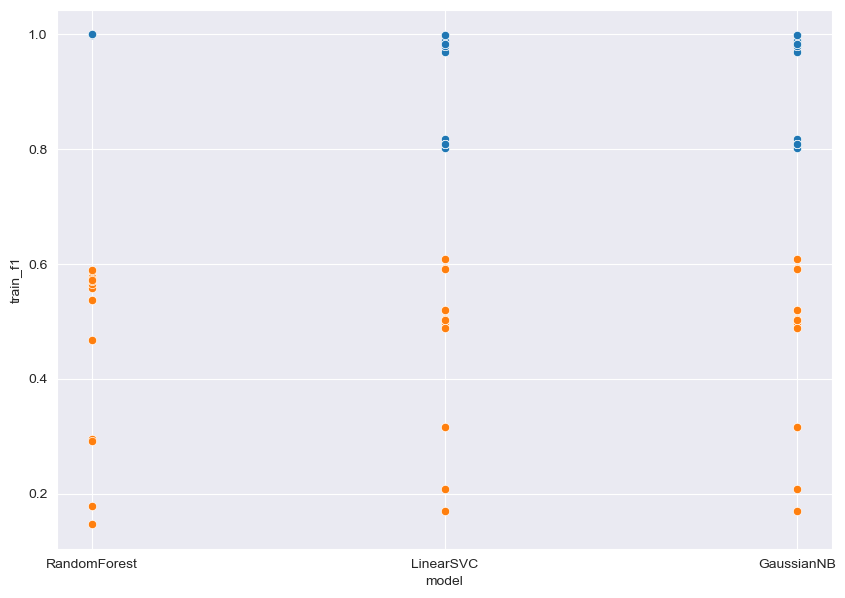

In [88]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(data=evaluation, y=evaluation['train_f1'], x=evaluation.model, ax=ax)
sns.scatterplot(data=evaluation, y=evaluation['test_f1'], x=evaluation.model, ax=ax)

plt.show()

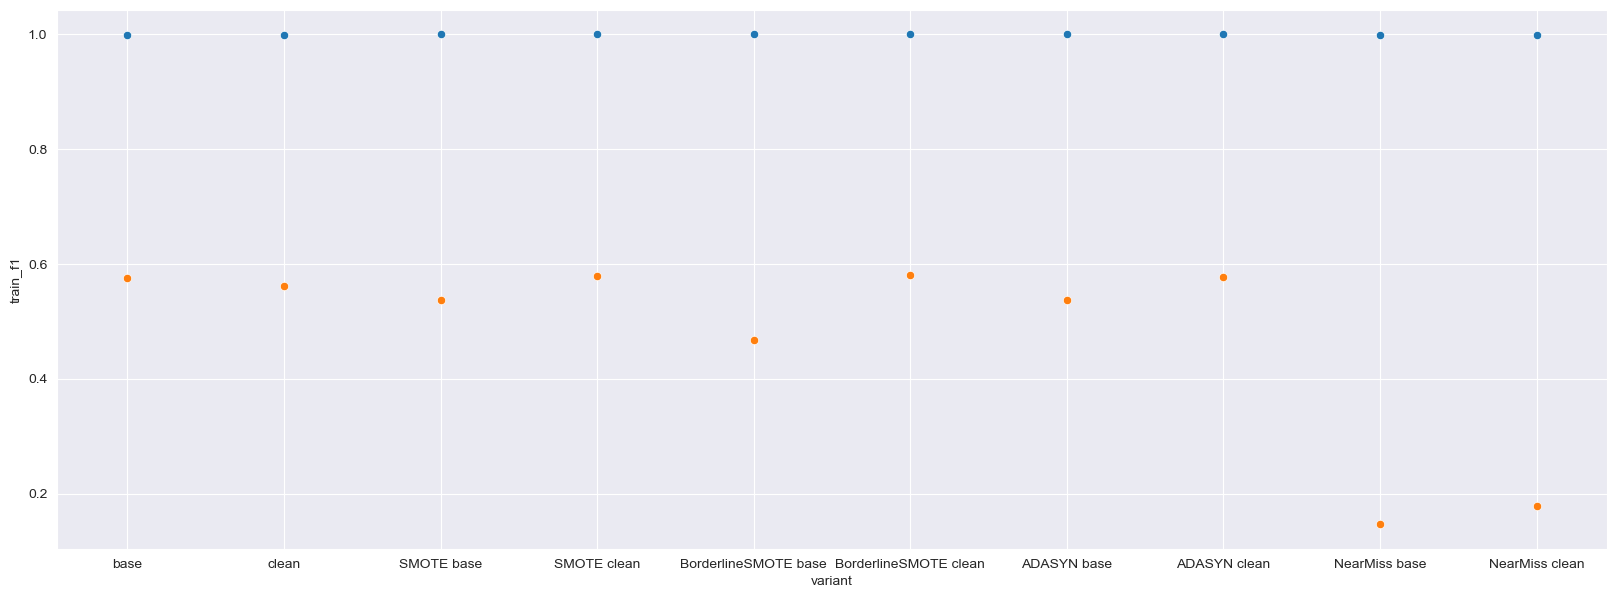

In [91]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.scatterplot(data=evaluation, y=evaluation['train_f1'].head(10), x=evaluation.variant, ax=ax)
sns.scatterplot(data=evaluation, y=evaluation['test_f1'].head(10), x=evaluation.variant, ax=ax)

plt.show()

<Axes: xlabel='model', ylabel='test_f1'>

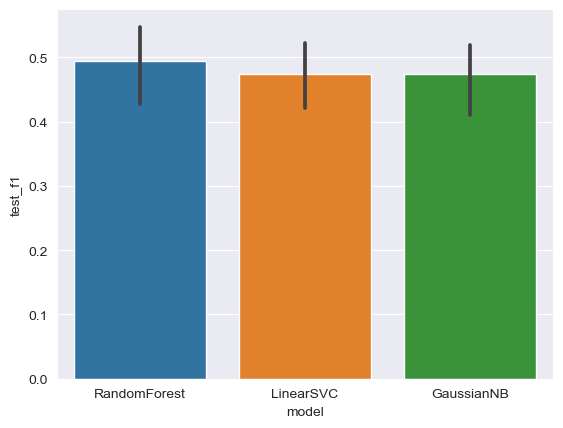

In [73]:
sns.barplot(data=evaluation, y=evaluation.test_f1, x=evaluation.model)